## Custom Project goal

- Write a custom graphQL query
- Connect to the AniList API and get data on animes with an average score of 85 or high
- Data to retrieve id, season, episodes, averageScore, popularity, countryOfOrigin, genres, status, title, startDate, endDate
- Transform and clean data
- Load aniList data into a in-memory SQL database for querying
- Vizualize the count of top animes released by year

## Import needed libraries

In [1]:
import requests
import pandas as pd
from InMemDB import InMemDB
from datetime import datetime
import warnings
import matplotlib.pyplot as plt
%matplotlib notebook
warnings.filterwarnings('ignore')

## Define Functions

In [2]:
def getDateInfo(row):
    
    m = row['month']
    m = str(m).replace('None','1')
    d = row['day']
    d = str(d).replace('None','1')
    y = row['year']
    y = str(y).replace('None','1')
    
    startDate = m + '-' + d + '-' + y
    
    return pd.to_datetime(startDate).strftime('%m-%d-%Y')

#------------------------------------------------------------------------------------

def listToString(s): 
    str1 = ""
    for ele in s:
        str1 += ele + ', '  
     
    return str1.strip()[:-1]

#------------------------------------------------------------------------------------

def returnYear(row):
    row = pd.to_datetime(row)
    return row.year


## Create a list of API request queries to iterate through as there is a page limit of 50 and there are 127 line items

In [3]:
queryList = []

for i in range(3):
    query = """

                query ($id: Int) {
                    Page """ + f'(page:{i + 1})' + """
                    
                    {

                    pageInfo {
                            total
                            currentPage
                            lastPage
                            hasNextPage
                            perPage
                        }

                    media (id: $id, averageScore_greater: 85) 

                    {
                    id

                    title {
                      english
                      romaji
                      userPreferred
                    }

                      season
                    , episodes
                    , averageScore
                    , popularity
                    , countryOfOrigin
                    , genres
                    , startDate {
                      year
                      month
                      day
                    }
                    , endDate {
                      year
                      month
                      day
                    }
                    , status 
                      }
                    }
                  }
                    """
    queryList.append(query)

## Request JSON data from the AniList API

In [4]:
aniListData = [requests.post(url = 'https://graphql.anilist.co', json={'query':q}, verify = False).json() for q in queryList]

## Slice the JSON data to only get the data needed

In [5]:
aniListData[0]['data']['Page']['media'][0:3]

[{'id': 5258,
  'title': {'english': 'Fighting Spirit: New Challenger',
   'romaji': 'Hajime no Ippo: New Challenger',
   'userPreferred': 'Hajime no Ippo: New Challenger'},
  'season': 'WINTER',
  'episodes': 26,
  'averageScore': 85,
  'popularity': 22121,
  'countryOfOrigin': 'JP',
  'genres': ['Comedy', 'Drama', 'Sports'],
  'startDate': {'year': 2009, 'month': 1, 'day': 7},
  'endDate': {'year': 2009, 'month': 7, 'day': 1},
  'status': 'FINISHED'},
 {'id': 20464,
  'title': {'english': 'HAIKYU!!',
   'romaji': 'Haikyuu!!',
   'userPreferred': 'Haikyuu!!'},
  'season': 'SPRING',
  'episodes': 25,
  'averageScore': 85,
  'popularity': 239148,
  'countryOfOrigin': 'JP',
  'genres': ['Comedy', 'Drama', 'Sports'],
  'startDate': {'year': 2014, 'month': 4, 'day': 6},
  'endDate': {'year': 2014, 'month': 9, 'day': 21},
  'status': 'FINISHED'},
 {'id': 30664,
  'title': {'english': 'Akira', 'romaji': 'Akira', 'userPreferred': 'Akira'},
  'season': None,
  'episodes': None,
  'averageScore

In [6]:
pd.DataFrame(aniListData[0]['data']['Page']['media']).head()

,id,title,season,episodes,averageScore,popularity,countryOfOrigin,genres,startDate,endDate,status
0,5258,"{'english': 'Fighting Spirit: New Challenger',...",WINTER,26.0,85,22121,JP,"[Comedy, Drama, Sports]","{'year': 2009, 'month': 1, 'day': 7}","{'year': 2009, 'month': 7, 'day': 1}",FINISHED
1,20464,"{'english': 'HAIKYU!!', 'romaji': 'Haikyuu!!',...",SPRING,25.0,85,239148,JP,"[Comedy, Drama, Sports]","{'year': 2014, 'month': 4, 'day': 6}","{'year': 2014, 'month': 9, 'day': 21}",FINISHED
2,30664,"{'english': 'Akira', 'romaji': 'Akira', 'userP...",None,NaN,85,16219,JP,"[Action, Sci-Fi]","{'year': 1982, 'month': 12, 'day': 20}","{'year': 1990, 'month': 6, 'day': 25}",FINISHED
3,30745,"{'english': 'Pluto', 'romaji': 'Pluto', 'userP...",None,NaN,85,15892,JP,"[Drama, Mecha, Mystery, Psychological, Sci-Fi]","{'year': 2003, 'month': 9, 'day': 9}","{'year': 2009, 'month': 4, 'day': 1}",FINISHED
4,97983,"{'english': 'Natsume's Book of Friends 6', 'ro...",SPRING,11.0,85,19298,JP,"[Drama, Fantasy, Slice of Life, Supernatural]","{'year': 2017, 'month': 4, 'day': 12}","{'year': 2017, 'month': 6, 'day': 21}",FINISHED


## Convert the list of dictionaries into a list of DataFrames

In [7]:
aniListDF = [pd.DataFrame(d['data']['Page']['media']) for d in aniListData]

In [8]:
aniListDF[0].head(3)

,id,title,season,episodes,averageScore,popularity,countryOfOrigin,genres,startDate,endDate,status
0,5258,"{'english': 'Fighting Spirit: New Challenger',...",WINTER,26.0,85,22121,JP,"[Comedy, Drama, Sports]","{'year': 2009, 'month': 1, 'day': 7}","{'year': 2009, 'month': 7, 'day': 1}",FINISHED
1,20464,"{'english': 'HAIKYU!!', 'romaji': 'Haikyuu!!',...",SPRING,25.0,85,239148,JP,"[Comedy, Drama, Sports]","{'year': 2014, 'month': 4, 'day': 6}","{'year': 2014, 'month': 9, 'day': 21}",FINISHED
2,30664,"{'english': 'Akira', 'romaji': 'Akira', 'userP...",None,NaN,85,16219,JP,"[Action, Sci-Fi]","{'year': 1982, 'month': 12, 'day': 20}","{'year': 1990, 'month': 6, 'day': 25}",FINISHED


In [9]:
aniListDF[0].head(3)

,id,title,season,episodes,averageScore,popularity,countryOfOrigin,genres,startDate,endDate,status
0,5258,"{'english': 'Fighting Spirit: New Challenger',...",WINTER,26.0,85,22121,JP,"[Comedy, Drama, Sports]","{'year': 2009, 'month': 1, 'day': 7}","{'year': 2009, 'month': 7, 'day': 1}",FINISHED
1,20464,"{'english': 'HAIKYU!!', 'romaji': 'Haikyuu!!',...",SPRING,25.0,85,239148,JP,"[Comedy, Drama, Sports]","{'year': 2014, 'month': 4, 'day': 6}","{'year': 2014, 'month': 9, 'day': 21}",FINISHED
2,30664,"{'english': 'Akira', 'romaji': 'Akira', 'userP...",None,NaN,85,16219,JP,"[Action, Sci-Fi]","{'year': 1982, 'month': 12, 'day': 20}","{'year': 1990, 'month': 6, 'day': 25}",FINISHED


## Concatenate the DataFrames into one

In [10]:
aniListDF = pd.concat(aniListDF).reset_index(drop=True)

In [11]:
len(aniListDF)

127

In [12]:
aniListDF.head(2)

,id,title,season,episodes,averageScore,popularity,countryOfOrigin,genres,startDate,endDate,status
0,5258,"{'english': 'Fighting Spirit: New Challenger',...",WINTER,26.0,85,22121,JP,"[Comedy, Drama, Sports]","{'year': 2009, 'month': 1, 'day': 7}","{'year': 2009, 'month': 7, 'day': 1}",FINISHED
1,20464,"{'english': 'HAIKYU!!', 'romaji': 'Haikyuu!!',...",SPRING,25.0,85,239148,JP,"[Comedy, Drama, Sports]","{'year': 2014, 'month': 4, 'day': 6}","{'year': 2014, 'month': 9, 'day': 21}",FINISHED


## Data exploration and cleaning

In [13]:
aniListDF['title'][0]

{'english': 'Fighting Spirit: New Challenger',
 'romaji': 'Hajime no Ippo: New Challenger',
 'userPreferred': 'Hajime no Ippo: New Challenger'}

In [14]:
aniListDF['title'][0]['english']

'Fighting Spirit: New Challenger'

In [15]:
aniListDF['English Title'] = [aniListDF['title'][i]['english'] for i in range(len(aniListDF))]

In [16]:
aniListDF['Romaji Title'] = [aniListDF['title'][i]['romaji'] for i in range(len(aniListDF))]

In [17]:
aniListDF['userPreferred Title'] = [aniListDF['title'][i]['userPreferred'] for i in range(len(aniListDF))]

In [18]:
aniListDF.drop(columns={'title'}, inplace=True)

In [19]:
aniListDF.head(4)

,id,season,episodes,averageScore,popularity,countryOfOrigin,genres,startDate,endDate,status,English Title,Romaji Title,userPreferred Title
0,5258,WINTER,26.0,85,22121,JP,"[Comedy, Drama, Sports]","{'year': 2009, 'month': 1, 'day': 7}","{'year': 2009, 'month': 7, 'day': 1}",FINISHED,Fighting Spirit: New Challenger,Hajime no Ippo: New Challenger,Hajime no Ippo: New Challenger
1,20464,SPRING,25.0,85,239148,JP,"[Comedy, Drama, Sports]","{'year': 2014, 'month': 4, 'day': 6}","{'year': 2014, 'month': 9, 'day': 21}",FINISHED,HAIKYU!!,Haikyuu!!,Haikyuu!!
2,30664,None,NaN,85,16219,JP,"[Action, Sci-Fi]","{'year': 1982, 'month': 12, 'day': 20}","{'year': 1990, 'month': 6, 'day': 25}",FINISHED,Akira,Akira,Akira
3,30745,None,NaN,85,15892,JP,"[Drama, Mecha, Mystery, Psychological, Sci-Fi]","{'year': 2003, 'month': 9, 'day': 9}","{'year': 2009, 'month': 4, 'day': 1}",FINISHED,Pluto,Pluto,Pluto


In [20]:
aniListDF['startDate'][0]['year']

2009

In [21]:
type(aniListDF['startDate'][0]['year'])

int

In [22]:
dateKeys = list(aniListDF['startDate'][0].keys())
dateKeys

['year', 'month', 'day']

In [23]:
aniListDF['startDate'].head()

0      {'year': 2009, 'month': 1, 'day': 7}
1      {'year': 2014, 'month': 4, 'day': 6}
2    {'year': 1982, 'month': 12, 'day': 20}
3      {'year': 2003, 'month': 9, 'day': 9}
4     {'year': 2017, 'month': 4, 'day': 12}
Name: startDate, dtype: object

In [24]:
aniListDF.apply(lambda row: getDateInfo(row['startDate']), axis=1).values[:6]

array(['01-07-2009', '04-06-2014', '12-20-1982', '09-09-2003',
       '04-12-2017', '07-12-1997'], dtype=object)

In [25]:
aniListDF['startDate2'] = aniListDF.apply(lambda row: getDateInfo(row['startDate']), axis=1)

In [26]:
aniListDF['endDate2'] = aniListDF.apply(lambda row: getDateInfo(row['endDate']), axis=1)

In [27]:
aniListDF.head(4)

,id,season,episodes,averageScore,popularity,countryOfOrigin,genres,startDate,endDate,status,English Title,Romaji Title,userPreferred Title,startDate2,endDate2
0,5258,WINTER,26.0,85,22121,JP,"[Comedy, Drama, Sports]","{'year': 2009, 'month': 1, 'day': 7}","{'year': 2009, 'month': 7, 'day': 1}",FINISHED,Fighting Spirit: New Challenger,Hajime no Ippo: New Challenger,Hajime no Ippo: New Challenger,01-07-2009,07-01-2009
1,20464,SPRING,25.0,85,239148,JP,"[Comedy, Drama, Sports]","{'year': 2014, 'month': 4, 'day': 6}","{'year': 2014, 'month': 9, 'day': 21}",FINISHED,HAIKYU!!,Haikyuu!!,Haikyuu!!,04-06-2014,09-21-2014
2,30664,None,NaN,85,16219,JP,"[Action, Sci-Fi]","{'year': 1982, 'month': 12, 'day': 20}","{'year': 1990, 'month': 6, 'day': 25}",FINISHED,Akira,Akira,Akira,12-20-1982,06-25-1990
3,30745,None,NaN,85,15892,JP,"[Drama, Mecha, Mystery, Psychological, Sci-Fi]","{'year': 2003, 'month': 9, 'day': 9}","{'year': 2009, 'month': 4, 'day': 1}",FINISHED,Pluto,Pluto,Pluto,09-09-2003,04-01-2009


In [28]:
aniListDF.drop(['startDate','endDate'], axis=1, inplace=True)

In [29]:
aniListDF.rename(columns={'startDate2':'startDate', 'endDate2':'endDate'},inplace=True)

In [30]:
aniListDF.columns

Index(['id', 'season', 'episodes', 'averageScore', 'popularity',
       'countryOfOrigin', 'genres', 'status', 'English Title', 'Romaji Title',
       'userPreferred Title', 'startDate', 'endDate'],
      dtype='object')

In [31]:
aniListDF['startYear'] = aniListDF.startDate.apply(returnYear)

In [32]:
aniListDF[['genres']].head(5)

,genres
0,"[Comedy, Drama, Sports]"
1,"[Comedy, Drama, Sports]"
2,"[Action, Sci-Fi]"
3,"[Drama, Mecha, Mystery, Psychological, Sci-Fi]"
4,"[Drama, Fantasy, Slice of Life, Supernatural]"


In [33]:
aniListDF['genres'] = aniListDF['genres'].apply(lambda row: listToString(row))

## Cleaned Data

In [34]:
aniListDF.head(5)

,id,season,episodes,averageScore,popularity,countryOfOrigin,genres,status,English Title,Romaji Title,userPreferred Title,startDate,endDate,startYear
0,5258,WINTER,26.0,85,22121,JP,"Comedy, Drama, Sports",FINISHED,Fighting Spirit: New Challenger,Hajime no Ippo: New Challenger,Hajime no Ippo: New Challenger,01-07-2009,07-01-2009,2009
1,20464,SPRING,25.0,85,239148,JP,"Comedy, Drama, Sports",FINISHED,HAIKYU!!,Haikyuu!!,Haikyuu!!,04-06-2014,09-21-2014,2014
2,30664,None,NaN,85,16219,JP,"Action, Sci-Fi",FINISHED,Akira,Akira,Akira,12-20-1982,06-25-1990,1982
3,30745,None,NaN,85,15892,JP,"Drama, Mecha, Mystery, Psychological, Sci-Fi",FINISHED,Pluto,Pluto,Pluto,09-09-2003,04-01-2009,2003
4,97983,SPRING,11.0,85,19298,JP,"Drama, Fantasy, Slice of Life, Supernatural",FINISHED,Natsume's Book of Friends 6,Natsume Yuujinchou Roku,Natsume Yuujinchou Roku,04-12-2017,06-21-2017,2017


## Import InMemDB (A module that I created please see InMemDB on my github) and load data for querying

- Queries:
    - Return animes with an average score above 90
    - Return top romantic comedies
    - Return the count of top animes released by year

In [35]:
 db = InMemDB()

In [36]:
db.CreateTableDF(df = aniListDF, table_name='aniList')

'aniList table has been created successfully'

In [37]:
dbQuery1 = '''

select * from aniList
where averageScore > 90

'''

In [38]:
db.query(dbQuery1)

,id,season,episodes,averageScore,popularity,countryOfOrigin,genres,status,English Title,Romaji Title,userPreferred Title,startDate,endDate,startYear
0,104578,SPRING,10.0,91,215215,JP,"Action, Drama, Fantasy, Mystery",FINISHED,Attack on Titan Season 3 Part 2,Shingeki no Kyojin 3 Part 2,Shingeki no Kyojin 3 Part 2,04-29-2019,07-01-2019,2019
1,30002,None,NaN,91,68032,JP,"Action, Adventure, Drama, Fantasy, Horror, Psy...",RELEASING,Berserk,Berserk,Berserk,08-25-1989,01-01-2001,1989


In [39]:
dbQuery2 = '''

select * from aniList
where genres like ('%Comedy%')
and genres like ('%Romance%')

'''

In [40]:
db.query(dbQuery2).head(10)

,id,season,episodes,averageScore,popularity,countryOfOrigin,genres,status,English Title,Romaji Title,userPreferred Title,startDate,endDate,startYear
0,2001,SPRING,27.0,85,160425,JP,"Action, Comedy, Drama, Mecha, Romance, Sci-Fi",FINISHED,Gurren Lagann,Tengen Toppa Gurren Lagann,Tengen Toppa Gurren Lagann,04-01-2007,09-30-2007,2007
1,7785,SPRING,11.0,85,64319,JP,"Comedy, Mystery, Psychological, Romance",FINISHED,The Tatami Galaxy,Yojouhan Shinwa Taikei,Yojouhan Shinwa Taikei,04-23-2010,07-02-2010,2010
2,39726,None,NaN,85,4264,JP,"Action, Comedy, Drama, Mystery, Romance, Super...",FINISHED,Zaregoto,Zaregoto Series,Zaregoto Series,02-05-2002,11-08-2005,2002
3,85850,None,NaN,85,9417,CN,"Comedy, Romance, Slice of Life",RELEASING,None,19 Tian,19 Tian,01-01-2014,01-01-2001,2014
4,70171,None,NaN,86,9924,JP,"Comedy, Drama, Romance, Slice of Life",FINISHED,My youth romantic comedy is wrong as I expected.,Yahari Ore no Seishun Love Come wa Machigatteiru.,Yahari Ore no Seishun Love Come wa Machigatteiru.,03-23-2011,11-19-2019,2011
5,111762,SPRING,25.0,86,64592,JP,"Comedy, Drama, Romance, Slice of Life, Superna...",FINISHED,Fruits Basket Season 2,Fruits Basket: 2nd Season,Fruits Basket: 2nd Season,04-07-2020,09-22-2020,2020
6,98842,None,NaN,86,26712,JP,"Action, Comedy, Drama, Mystery, Romance, Super...",RELEASING,Toilet-Bound Hanako-kun,Jibaku Shounen Hanako-kun,Jibaku Shounen Hanako-kun,06-18-2014,01-01-2001,2014
7,51525,None,NaN,86,18551,JP,"Action, Adventure, Comedy, Fantasy, Romance",RELEASING,Yona of the Dawn,Akatsuki no Yona,Akatsuki no Yona,08-05-2009,01-01-2001,2009
8,112641,SPRING,12.0,86,162978,JP,"Comedy, Psychological, Romance, Slice of Life",FINISHED,Kaguya-sama: Love is War?,Kaguya-sama wa Kokurasetai?: Tensai-tachi no R...,Kaguya-sama wa Kokurasetai?: Tensai-tachi no R...,04-11-2020,06-27-2020,2020
9,124194,SPRING,NaN,87,37098,JP,"Comedy, Drama, Romance, Supernatural",RELEASING,Fruits Basket The Final Season,Fruits Basket: The Final,Fruits Basket: The Final,04-06-2021,01-01-2001,2021


In [41]:
dbQuery3 = """

select startYear, count(id) as [Top Animes Released]
from aniList
group by startYear

"""

In [42]:
releaseByYearDF = db.query(dbQuery3)

releaseByYearDF.head(5)

,startYear,Top Animes Released
0,1968,1
1,1980,1
2,1982,1
3,1985,1
4,1988,1


## Test Case (Data vizualization with matplotlib)

- of the top 127 animes how many were realeased each year?

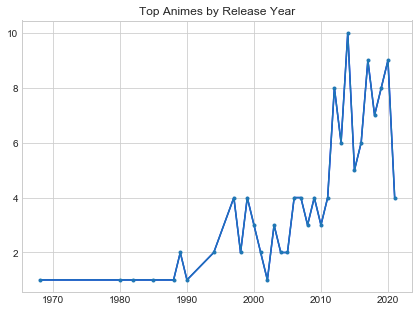

In [43]:
plt.figure(figsize=(7, 5))
plt.style.use('seaborn-whitegrid')
plt.plot(releaseByYearDF.startYear, releaseByYearDF['Top Animes Released'], color='blue')
plt.plot(releaseByYearDF.startYear, releaseByYearDF['Top Animes Released'], linestyle=None, marker='.')
plt.title('Top Animes by Release Year')
plt.show()
